# Monte Carlo 2D Ising Model: Heat Bath Algorithm

NxN spins, B = 0, J = 1, k = 1

In [1]:
from math import *
from random import *
import numpy as np
import matplotlib.pyplot as plt

Some basic conditions (to test functions & debugging):

In [2]:
N = 5 #length of ising model
I = np.ones((N,N)) #all spins up, periodic bounday conditions
T = 3 #final temp, near critical region
beta_0 = 1/T #make k = 1 here for simplicity
print(I)

[[1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]]


In [3]:
I = [[1,2,3],[4,5,6],[7,8,9]]
print(I)
I = np.asarray(I)
print(I)
for i in range(len(I)):
    for j in range(len(I)):
        print(I[i,j])

[[1, 2, 3], [4, 5, 6], [7, 8, 9]]
[[1 2 3]
 [4 5 6]
 [7 8 9]]
1
2
3
4
5
6
7
8
9


Defining functions that calculate internal energy, flip a spin, and energy change when flipping a spin:

In [4]:
def E(ising_array): #gets energy in 2D ising array, must have more than 2 by 2 grid.
    total_E = 0
    for i in range(len(ising_array)):
        for j in range(len(ising_array)):
            total_E += -ising_array[i, j]*ising_array[(i+1)%len(ising_array), j] - ising_array[i, j]*ising_array[i, (j + 1)%len(ising_array)] #periodic sum
    return total_E

In [5]:
def M(ising_array): #gets magnetization in ising array
    total_M = 0
    for i in range(len(ising_array)):
        for j in range(len(ising_array)):
            total_M += ising_array[i,j]
    return total_M

In [6]:
def flip(ising_array, n, m): #just flips spin in position (n, m)
    ising_array[n, m] = -ising_array[n, m]  #updated array
    return 0

In [7]:
def flip_dE(ising_array, n, m): #energy change when flipping spin in position (n,m)
    dE = 2*ising_array[n,m]*(ising_array[n,(m-1)%len(ising_array)]+ising_array[n,(m+1)%len(ising_array)]+ising_array[(n+1)%len(ising_array),m] + ising_array[(n-1)%len(ising_array),m])
    return dE

In [8]:
def flip_dM(ising_array, n, m): #magnetization change when flipping a spin
    return -2*ising_array[n, m]

In [9]:
def auto_correlation(m, t_max, t): #returns chi(t), needed to measure integrated correlation time
    sum1 = 0
    sum2 = 0
    sum3 = 0
    
    for i in range(t_max - t):
        #print(i+t)
        sum1 += m[i] * m[i + t]
        
        
    for i in range(t_max - t):
        sum2 += m[i]
        
    for i in range(t_max - t):
        sum3 += m[i + t]
        
    return sum1/(t_max - t) - sum2 * sum3 / (t_max - t)**2

In [10]:
def corr_time(chi_list):
    tau = 0
    
    for i in range(len(chi_list)):
        tau += chi_list[i]/chi_list[0]
    
    return tau

Using the above functions, we can apply the heat bath algorithm to N randomly
chosen spins (sweep):

In [11]:
def cycle(ising_array, beta, E_ising, M_ising): #does 1 sweep
    E_change = 0
    M_change = 0
    for k in range(len(ising_array) ** 2): 
        i = randint(0, len(ising_array) - 1)
        j = randint(0, len(ising_array) - 1) #random (i, j) spin is chosen
        
        d_E = flip_dE(ising_array, i, j)
        d_M = flip_dM(ising_array, i, j)
        
        
        A = np.exp(-0.5 * beta * d_E)/(np.exp(-0.5 * beta * d_E) + np.exp(0.5 * beta * d_E))
                
        if(random() < A):
                flip(ising_array, i, j) #much more likely to transition down than up...
                E_change += d_E
                M_change += d_M
            
                
    return [E_ising + E_change, M_ising + M_change]

In [12]:
def m_cycle(ising_array, beta, E_ising, M_ising): #does 1 sweep, metropolis
    E_change = 0
    M_change = 0
    for k in range(len(ising_array) ** 2): 
        i = randint(0, len(ising_array) - 1)
        j = randint(0, len(ising_array) - 1) #random (i, j) spin is chosen
        
        d_E = flip_dE(ising_array, i, j)
        d_M = flip_dM(ising_array, i, j)
        
        
        A = np.exp(-beta*d_E)
        
        if(d_E < 0):
            flip(ising_array, i, j)
            E_change += d_E
            M_change += d_M
            
      
        else:
            if(random() < A):
                flip(ising_array, i, j) #much more likely to transition down than up...
                E_change += d_E
                M_change += d_M
                
                
    return [E_ising + E_change, M_ising + M_change]

Acceptance ratio plot for heat bath algorithm:

Text(0, 0.5, 'Acceptance Ratio')

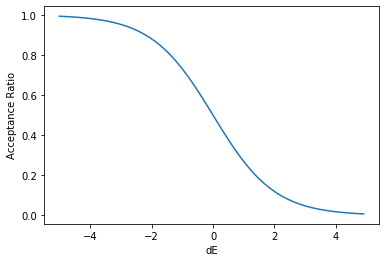

In [13]:
def A(d_E):
    beta = 1
    return np.exp(-0.5 * beta * d_E)/(np.exp(-0.5 * beta * d_E) + np.exp(0.5 * beta * d_E))

x = np.arange(-5,5, 0.1)
y = A(x)
plt.plot(x,y)
plt.xlabel("dE")
plt.ylabel("Acceptance Ratio")

Running a simulation to equilibrium conditions takes around 1000 sweeps (possibly more for low T),
since the simulation is longer near the critical region (where the phase 
transition from ferromagnet to paramegnet occurs)

In [14]:
def simulation(ising_array, beta): #simulation with metropolis
    E_element = E(I)
    M_element = M(I)
    E_list = []
    m_list = []
    for i in range(10000):
        E_element, M_element = cycle(I, beta, E_element, M_element)
        if(i > 1000 and i%20 == 0):
            m_list.append(M_element/len(I))
            E_list.append(E_element)
                
    return [E_list, m_list]

In [82]:
def m_simulation(ising_array, beta): #simulation with metropolis
    E_element = E(I)
    M_element = M(I)
    E_list = []
    m_list = []
    for i in range(10000): #FIX THIS FOR RUNNING NORMAL SIMULATION
        E_element, M_element = m_cycle(I, beta, E_element, M_element)
        if(i > 1000 and i%1 == 0):
            m_list.append(M_element/len(I))
            E_list.append(E_element)
                
    return [E_list, m_list]

In [16]:
I = np.ones((5,5))
I
a = simulation(I, 0.1)
I
np.average(a[0])

-4.850779510022272

In [18]:
I = np.ones((10,10))
I
a = m_simulation(I, 0.1)
I
np.average(a[0])

-20.819599109131403

To get <q^2>, just convert q_array to numpy array and then np.average(q_array**2). 

In [19]:
def simple_error(q_array): #gets the error for simple averaged parameters like energy, magnetization
    q_array = np.asarray(q_array)
    sigma = np.sqrt((np.average(q_array**2) - np.average(q_array)**2)/len(q_array))
    return sigma

In [20]:
def specific_heat(e_l, beta, spin_num): #gets specific heat from energy list
    e_l = np.asarray(e_l)
    return ((beta**2)/spin_num) * (np.average(e_l**2) - np.average(e_l)**2)

In [21]:
def c_bootstrap(e_l, beta, spin_num): #bootstrap error method, used to calculate specific heat error from overall energy list 
    e_l = np.asarray(e_l)
    c_list = []
    for i in range(10): #do this process 10 times
        temp_list = []
        for j in range(len(e_l)):
            index = randint(0, len(e_l)-1)
            temp_list.append(e_l[index])
        c_list.append(specific_heat(temp_list, beta, spin_num))
        #print(c_list) #troubleshoot
    c_list = np.asarray(c_list)
    sigma = np.sqrt(np.average(c_list**2) - np.average(c_list)**2)
    return sigma
        
    

In [70]:
list1 = [1,2,3,4,5]
list1[-2:]
for i in range(3, 7):
    print(i)

3
4
5
6


Getting integrated correlation time: Correlation time time is low when not near critical temperature, but becomes very large near critical temperature. For this code to work, we have to change the simulation function to record after each sweep. Analyzing relation tau \propto L^z

In [87]:
b0 = 1/2.26 #near critical temp

tau_list = []

for L in range(5, 15):
    tau_sum = 0
    for j in range(20):
        I = np.ones((L,L))

        E_array = m_simulation(I, b0)[0]
        m_array = m_simulation(I, b0)[1] #get metropolis simulation data 

        chi_array = []

        for i in range(1000): #get chi(0) to chi(1000)
            chi_array.append(auto_correlation(m_array, 4000, i)) #t_max = 450, t = i
        
        tau_add = corr_time(chi_array) 
        tau_sum += tau_add
        
    tau_avg = tau_sum/20
    tau_list.append(tau_avg)
    print(tau_avg)
    
tau_list

45.17842560791938
68.91726239891102
121.19640044115492
160.55098927099863
108.04928758544341
180.46956377668462
234.8877287218968
294.12620296251
199.12594189941524
208.34611667205732


[45.17842560791938,
 68.91726239891102,
 121.19640044115492,
 160.55098927099863,
 108.04928758544341,
 180.46956377668462,
 234.8877287218968,
 294.12620296251,
 199.12594189941524,
 208.34611667205732]

Trying to see a relation between c_crit and L

In [90]:
np.arange(5, 15)

array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14])

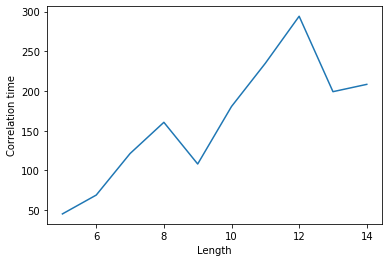

In [92]:
L_array = np.arange(5, 15)
corr_time_array = [45.17842560791938, 68.91726239891102, 121.19640044115492, 160.55098927099863, 108.04928758544341, 180.46956377668462, 234.8877287218968, 294.12620296251, 199.12594189941524, 208.34611667205732]
plt.plot(L_array, corr_time_array)
plt.xlabel("Length")
plt.ylabel("Correlation time")
plt.savefig("Relation between correlation time and length")

In [24]:
print(simple_error(E_array))
I
print(np.average(E_array))

0.9169285779986696
-81.184855233853


In [ ]:
T_array = np.linspace(2, 3, 10)

beta_array = 1/T_array

m_c_comp = []
c_crit = []

for L in range(4, 22, 2):
    m_c_comp = []
    for i in range(len(beta_array)):
        I = np.ones((L, L))
        m_results =  m_simulation(I, beta_array[i]) #metropolis algorithm

        m_energy_list = m_results[0]
        m_m_list = m_results[1]

        m_c_comp.append(specific_heat(m_energy_list, beta_array[i], len(I)))
        
    c_crit.append(np.max(m_c_comp))    
    print(c_crit)

print("Done")

print(c_crit)

In [ ]:
c_crit = [3.463403020259496, 6.65362102896921, 9.444005632868079, 14.719338066127586, 16.833568103656866, 21.67091916092142, 25.610895192150192, 30.447409709763168, 34.68463384606248]
 208.34611667205732]
plt.plot(np.arange(4, 22, 2), c_crit)
plt.xlabel("Length")
plt.ylabel("Specific Heat at critical Temperature")
plt.savefig("Critical specific heat with model size")

Comparing analytic to computationally determined energies at a variety of temperatures:

In [25]:
N = 10
T_array = np.asarray([16, 25, 36, 49, 64, 81, 100])
beta_array = 1/T_array #k = 1
E_analytic = -N**2 *np.tanh(1/T_array)

E_comp = [] #heat bath
m_E_comp = [] #metropolis

for i in range(len(T_array)):
    I = np.ones((N,N))
    E_comp.append(np.average(simulation(I, 1/T_array[i])[0]))
    m_E_comp.append(np.average(m_simulation(I, 1/T_array[i])[0]))
    
plt.plot(T_array, E_comp, label="Heat Bath")
plt.plot(T_array, m_E_comp, label="Metropolis")
plt.legend()
plt.xlabel("T")
plt.ylabel("Energy")
plt.show()


KeyboardInterrupt: 

In [29]:
print(np.linspace(0.1, 1.4, 10))
print(np.linspace(1.5, 3, 25))
print(np.linspace(3.1, 10, 15))
T_array2 = np.concatenate((np.linspace(0.1, 1.4, 10), np.linspace(1.5, 3, 25), np.linspace(3.1, 10, 15)))
print(T_array2)

[0.1        0.24444444 0.38888889 0.53333333 0.67777778 0.82222222
 0.96666667 1.11111111 1.25555556 1.4       ]
[1.5    1.5625 1.625  1.6875 1.75   1.8125 1.875  1.9375 2.     2.0625
 2.125  2.1875 2.25   2.3125 2.375  2.4375 2.5    2.5625 2.625  2.6875
 2.75   2.8125 2.875  2.9375 3.    ]
[ 3.1         3.59285714  4.08571429  4.57857143  5.07142857  5.56428571
  6.05714286  6.55        7.04285714  7.53571429  8.02857143  8.52142857
  9.01428571  9.50714286 10.        ]
[ 0.1         0.24444444  0.38888889  0.53333333  0.67777778  0.82222222
  0.96666667  1.11111111  1.25555556  1.4         1.5         1.5625
  1.625       1.6875      1.75        1.8125      1.875       1.9375
  2.          2.0625      2.125       2.1875      2.25        2.3125
  2.375       2.4375      2.5         2.5625      2.625       2.6875
  2.75        2.8125      2.875       2.9375      3.          3.1
  3.59285714  4.08571429  4.57857143  5.07142857  5.56428571  6.05714286
  6.55        7.04285714  7.53571429

Calculating energy, magnetization, specific heat:

In [30]:
N = 5
#T_array2 = np.linspace(0.1, 10, 100) 
T_array2 = np.concatenate((np.linspace(0.1, 1.4, 10), np.linspace(1.5, 3, 25), np.linspace(3.1, 10, 15)))
beta_array = 1/T_array2

E_comp = []
E_error = [] 
m_comp = []
m_error = []
c_comp = []
c_error = []#heat bath stuff

m_E_comp = []
m_E_error = []
m_m_comp = []
m_m_error = []
m_c_comp = []
m_c_error = []#metroplis

for i in range(len(T_array2)):
    I = np.ones((N, N))
    results = simulation(I, 1/T_array2[i]) #heat bath simulation
    
    energy_list = results[0]
    m_list = results[1]
    
    E_comp.append(np.average(energy_list))
    E_error.append(simple_error(energy_list)) #energy from heat bath
    
    m_comp.append(np.average(m_list))
    m_error.append(simple_error(m_list)) #magnetization from heat bath
    
    c_comp.append(specific_heat(energy_list, beta_array[i], len(I)))
    c_error.append(c_bootstrap(energy_list, beta_array[i], len(I))) #specific heat from heat bath
    
    I = np.ones((N, N))
    m_results =  m_simulation(I, 1/T_array2[i]) #metropolis algorithm
    
    m_energy_list = m_results[0]
    m_m_list = m_results[1]
    
    m_E_comp.append(np.average(m_energy_list))
    m_E_error.append(simple_error(m_energy_list)) #energy from metropolis
    
    m_m_comp.append(np.average(m_m_list))
    m_m_error.append(simple_error(m_m_list)) #magnetization from metropolis
    
    m_c_comp.append(specific_heat(m_energy_list, beta_array[i], len(I)))
    m_c_error.append(c_bootstrap(m_energy_list, beta_array[i], len(I))) #specific heat from metropolis
    print("Done")



plt.errorbar(T_array2, E_comp, yerr = E_error, label="Heat Bath", color = "orange")
plt.errorbar(T_array2, m_E_comp, yerr = m_E_error, label="Metropolis", color = "green")
plt.legend()
plt.xlabel("T")
plt.ylabel("Energy")
plt.title("Energy Plot")
plt.savefig("energy_2D.pdf")
plt.clf()

plt.errorbar(T_array2, m_comp, yerr = m_error, label="Heat Bath", color = "orange")
plt.errorbar(T_array2, m_m_comp, yerr = m_m_error, label="Metropolis", color = "green")
plt.legend()
plt.xlabel("T")
plt.ylabel("Magnetization")
plt.title("Magnetization")
plt.savefig("magnetization_2D.pdf")
plt.clf()

plt.errorbar(T_array2, c_comp, yerr = c_error, label="Heat Bath", color = "orange")
plt.errorbar(T_array2, m_c_comp, yerr = m_c_error, label="Metropolis", color = "green")
plt.legend()
plt.xlabel("T")
plt.ylabel("Specific Heat")
plt.title("Specific Heat")
plt.savefig("specific_heat_2D.pdf")
plt.clf()

Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done


<Figure size 432x288 with 0 Axes>

In [31]:
print("Heat bath energy:")
print(E_comp)

print("Metropolis energy:")
print(m_E_comp)

print("Heat bath magnetization:")
print(m_comp)

print("Metropolis magnetization:")
print(m_m_comp)

print("Heat bath specific heat:")
print(c_comp)

print("Metropolis specific heat:")
print(m_c_comp)

print("Heat bath energy error:")
print(E_error)

print("Metropolis energy error:")
print(m_E_error)

print("Heat bath magnetization error:")
print(m_error)

print("Metropolis magnetization error:")
print(m_m_error)

print("Heat bath specific heat error:")
print(c_error)

print("Metropolis specific heat error:")
print(m_c_error)


Heat bath energy:
[-50.0, -50.0, -50.0, -50.0, -50.0, -50.0, -49.928730512249444, -49.86636971046771, -49.69710467706013, -49.34966592427617, -48.89532293986637, -48.53897550111358, -47.98663697104677, -47.53229398663697, -46.801781737193764, -46.0, -45.30512249443207, -44.334075723830736, -43.74610244988864, -42.73942093541203, -41.046770601336306, -40.55679287305122, -38.15144766146993, -37.27839643652561, -36.6815144766147, -33.94654788418708, -33.16258351893096, -30.64142538975501, -30.51670378619154, -28.948775055679288, -27.514476614699333, -26.64142538975501, -25.679287305122493, -24.71714922048998, -23.33630289532294, -22.543429844097997, -16.70824053452116, -13.875278396436526, -12.102449888641425, -10.115812917594655, -10.044543429844097, -8.66369710467706, -7.719376391982182, -7.371937639198218, -6.614699331848552, -6.783964365256125, -6.285077951002227, -5.5456570155902005, -5.180400890868597, -4.636971046770602]
Metropolis energy:
[-50.0, -50.0, -50.0, -50.0, -50.0, -50.0,

In [ ]:
c_comp

Calculating magnetization:

In [ ]:
N = 5
T_array2 = np.linspace(0.1, 5, 25)
m_comp = []
m_error = [] #heat bath

m_m_comp = []
m_m_error = [] #metropolis


for i in range(len(T_array2)):
    I = np.ones((N, N))
    m_list = simulation(I, 1/T_array2[i])[1]
    m_comp.append(np.average(m_list))
    m_error.append(simple_error(m_list)) #heat bath
    
    m_m_list = m_simulation(I, 1/T_array2[i])[1]
    m_m_comp.append(np.average(m_m_list))
    m_m_error.append(simple_error(m_m_list)) #metroplis
    

plt.errorbar(T_array2, m_comp, yerr = m_error, label="Heat Bath", color = "orange")
plt.errorbar(T_array2, m_m_comp, yerr = m_m_error, label="Metropolis", color = "green")
plt.legend()
plt.xlabel("T")
plt.ylabel("Magnetization")
plt.show()


Calculating specific heat:

In [ ]:
N = 5
T_array2 = np.linspace(0.1, 5, 25)
beta_array = 1/T_array2
c_comp = []
c_error = [] #heat bath

m_c_comp = []
m_c_error = [] #metroplis

for i in range(len(T_array2)):
    I = np.ones((N, N))
    energy_list = simulation(I, 1/T_array2[i])[0]
    c_comp.append(specific_heat(energy_list, beta_array[i], len(I)))
    c_error.append(c_bootstrap(energy_list, beta_array[i], len(I)))
    
    m_energy_list = m_simulation(I, 1/T_array2[i])[0]
    m_c_comp.append(specific_heat(m_energy_list, beta_array[i], len(I)))
    m_c_error.append(c_bootstrap(m_energy_list, beta_array[i], len(I)))
    
    
plt.errorbar(T_array2, c_comp, yerr = c_error, label="Heat Bath", color = "orange")
plt.errorbar(T_array2, m_c_comp, yerr = m_c_error, label="Metropolis", color = "green")
plt.legend()
plt.xlabel("T")
plt.ylabel("Specific Heat")
plt.show()